# Load Data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2165 entries, 2013-01-07 00:00:00 to 2023-04-18 00:00:00
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      2165 non-null   int64  
 1   C_Price         2165 non-null   float64
 2   C_Price_min     2165 non-null   float64
 3   C_Price_max     2165 non-null   float64
 4   C_Price_mean    2165 non-null   float64
 5   C_Price_median  2165 non-null   float64
 6   E_Price         1572 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 135.3 KB
None
            Unnamed: 0  C_Price  C_Price_min  C_Price_max  C_Price_mean  \
Date                                                                      
2013-01-07           0     6.18         5.75         6.50          6.10   
2013-01-08           1     6.35         5.19         6.56          6.26   
2013-01-10           2     5.93         4.00         6.25          5.87   
2013-01-11           

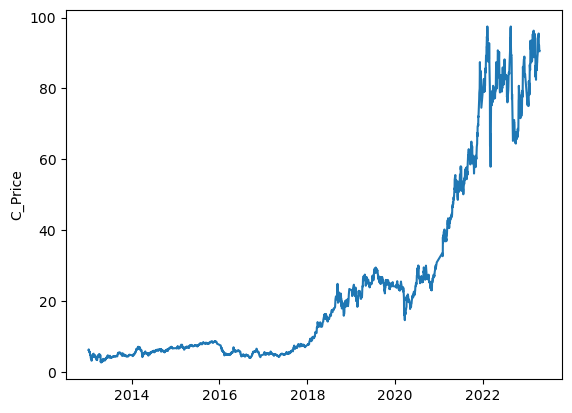

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from method import HiddenPrints

# load data
df = pd.read_excel('data\source\CCprice.xlsx', sheet_name='Sheet1')
df = df.set_index('Date')
df.index = pd.DatetimeIndex(df.index)
df.index.freq = df.index.inferred_freq
date_col = df.index

# overview of data
print(df.info())
print(df.head())
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(date_col, df['C_Price'])
ax1.set_ylabel('C_Price')
plt.show()

y = np.array(df['C_Price'])[-1500:]
t = range(len(y))

# Rolling window

In [2]:
win_len = 200
print(len(y)-win_len-1)

t = 500
win_x = y[t:t+win_len]
win_y = y[t+win_len]

# win_xs = []
# win_ys = []
# for t in range(len(y)-win_len-1):
#     win_xs.append(y[t:t+win_len])
#     win_ys.append(y[t+win_len])
# print(np.array(win_xs).shape)

# t = 500
# win_x = win_xs[t]
# win_y = win_ys[t]

1299


## Restructuring

1.588871507985552e-14
1.585491772472275e-14


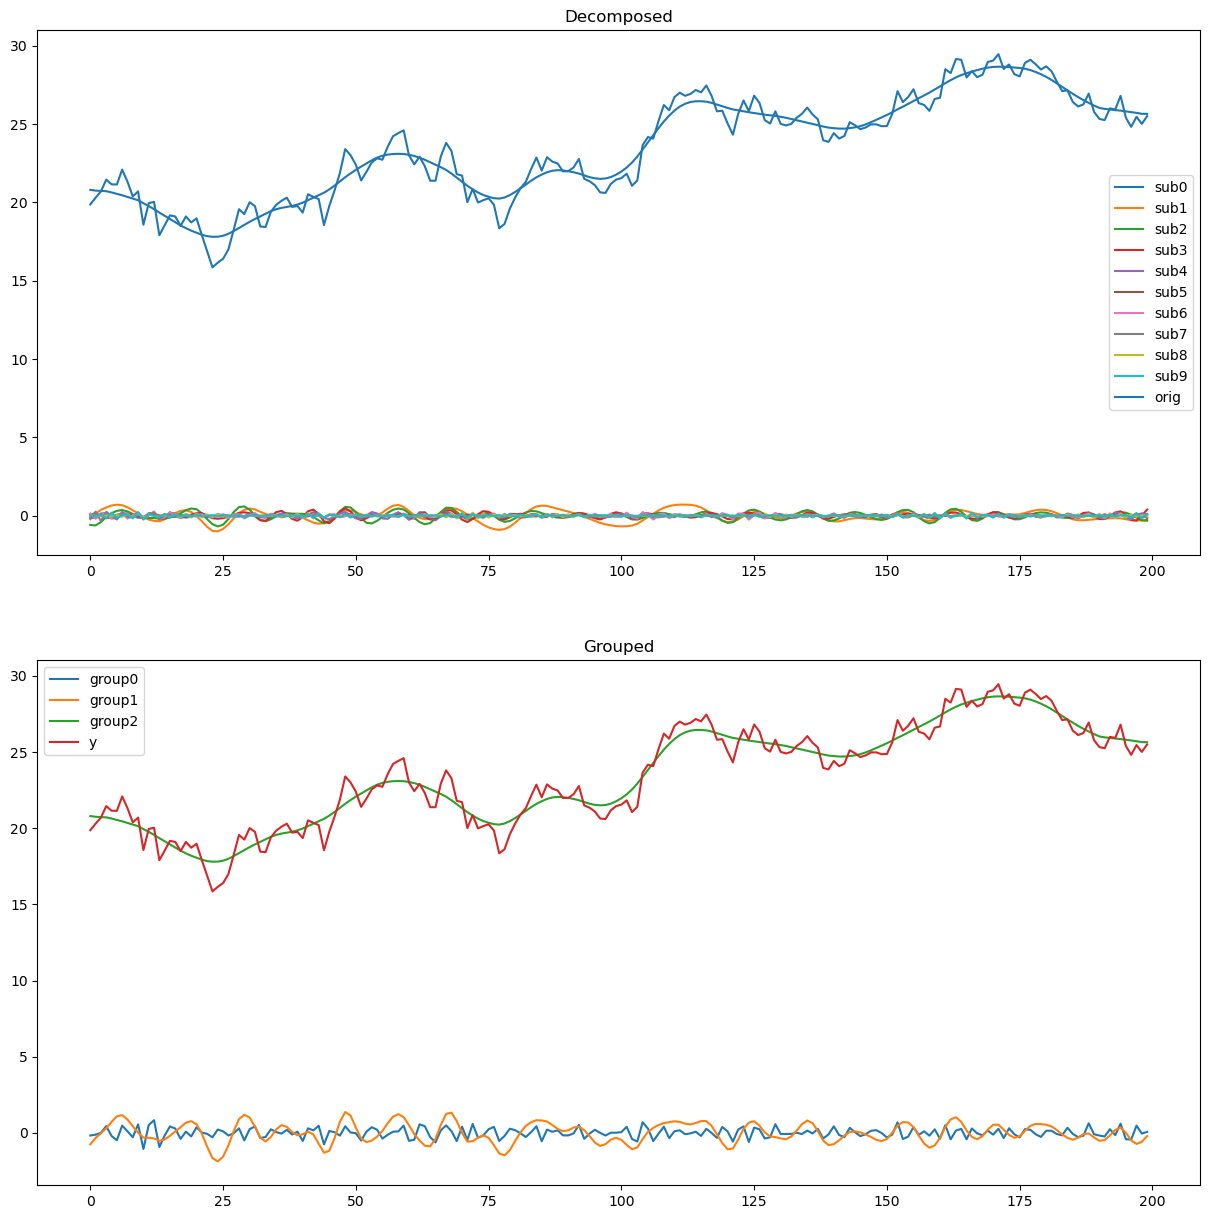

In [3]:
from series_restr import *

# ### EMD++
# # decompose
# imfs = decomp_ceemdan(win_x)
# # imfs = decomp_eemd(win_x)
# # imfs = decomp_emd(win_x)

# # integrate
# reconstr = integr_fuzzen_pwlf(imfs, n_integr=2)
# # reconstr = integr_fine_to_coarse(imfs)
# # reconstr = integr_fuzzen_threshold(imfs)

# vis_restr(imfs, reconstr, win_x)


### ssa
reconstr = restr_ssa(win_x, vis=True)

## High-freq forecast with ARIMA

In [4]:
# with HiddenPrints():
#     pred, model_arima = forecast_arima(win_x)
# print(pred)
# print(win_y)

In [5]:
from sarimax import *
hi_freq = reconstr[0,:]

print(stattools.adfuller(hi_freq)[1])

1.1301626714948244e-19


In [8]:
with HiddenPrints():
    hi_freq_pred, model_arima = forecast_arima(hi_freq)
print(hi_freq_pred)

-0.015985478139931848


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  200
Model:               SARIMAX(2, 0, 3)   Log Likelihood                 125.116
Date:                Sun, 11 Jun 2023   AIC                           -238.231
Time:                        20:38:57   BIC                           -218.441
Sample:                             0   HQIC                          -230.223
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4841      0.054      8.897      0.000       0.377       0.591
ar.L2         -0.6729      0.058    -11.576      0.000      -0.787      -0.559
ma.L1         -2.4857      0.301     -8.267      0.0

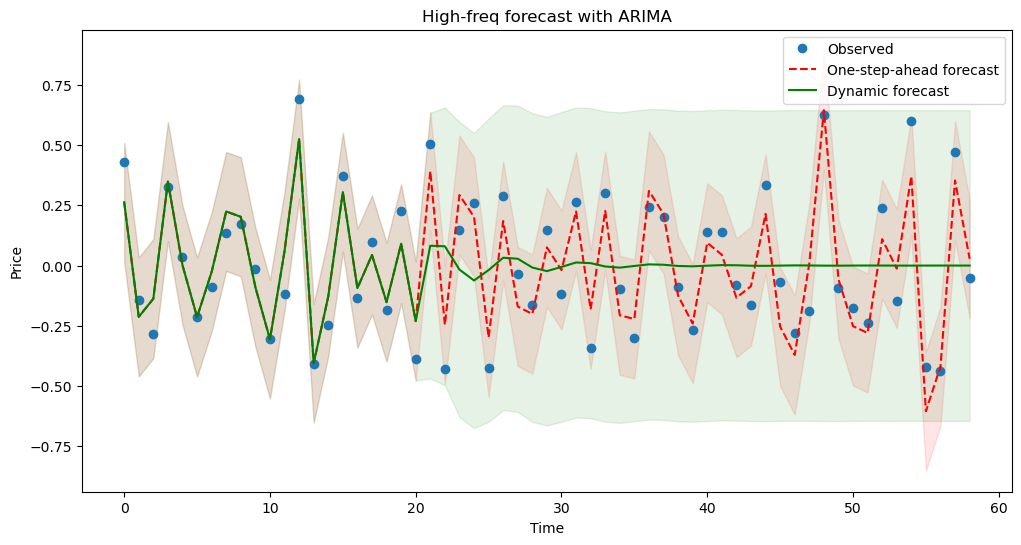

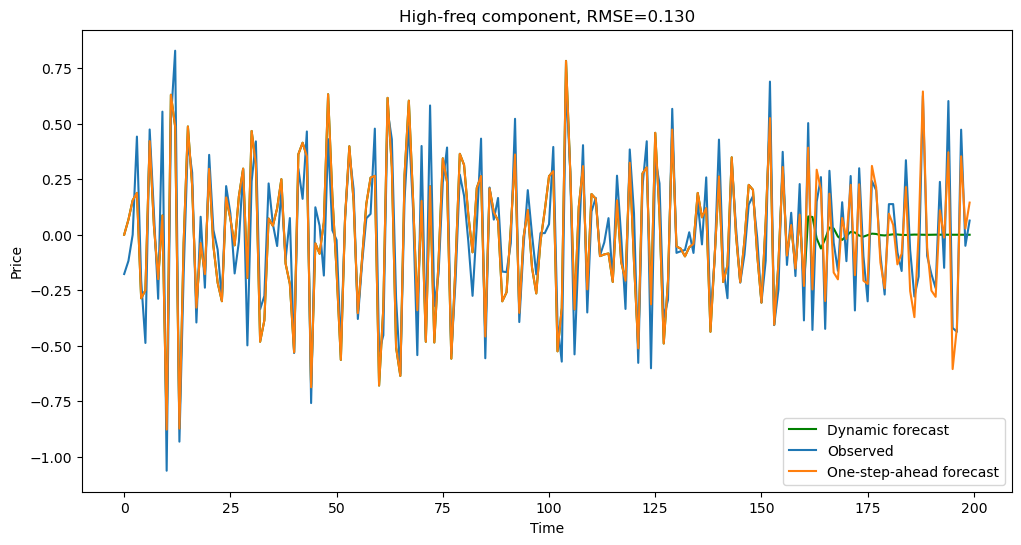

In [9]:
plot_prediction(model_arima, hi_freq)

## ARIMA-GARCH

In [34]:
# for orig series (hi_freq)

from statsmodels.tsa.stattools import adfuller #ADF单位根检验
from statsmodels.tsa import stattools #白噪声检验:Ljung-Box检验

# 平稳性检验
result = adfuller(hi_freq)
print(result[1]) # 小于0.05，拒绝原假设，原序列不存在单位根，即原序列平稳

# 白噪声检验
LjungBox = stattools.q_stat(stattools.acf(hi_freq)[1:12],len(hi_freq)) #显示第1个到第11个白噪声检验的p值
LjungBox[1]  #所有p值小于0.05，因此拒绝原假设，原序列不是白噪声，原序列具有ARCH效应

1.3683610589243767e-15


array([8.23526844e-59, 2.45379862e-78, 2.06460071e-82, 1.94366588e-81,
       4.98233773e-81, 1.89533642e-80, 6.40107115e-80, 1.38664946e-79,
       5.29793013e-80, 5.98436679e-84, 8.15797526e-93])

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  500
Model:               SARIMAX(2, 0, 1)   Log Likelihood                -364.368
Date:                Wed, 07 Jun 2023   AIC                            736.735
Time:                        15:55:29   BIC                            753.593
Sample:                             0   HQIC                           743.350
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6740      0.026     65.105      0.000       1.624       1.724
ar.L2         -0.7399      0.024    -30.367      0.000      -0.788      -0.692
ma.L1         -0.9406      0.018    -52.312      0.0

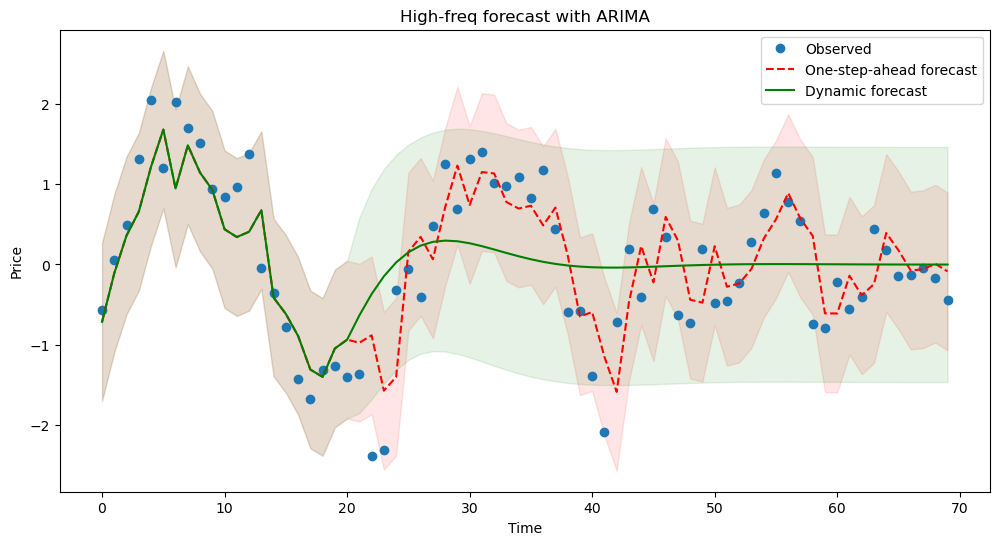

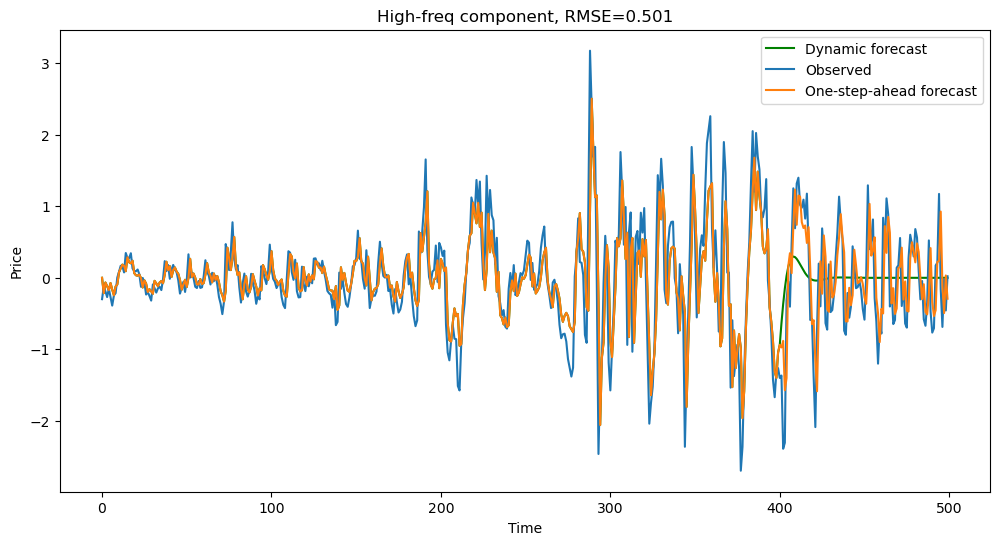

In [35]:
# fit arima
with HiddenPrints():
    hi_freq_pred, model_arima = forecast_arima(hi_freq)
plot_prediction(model_arima, hi_freq)

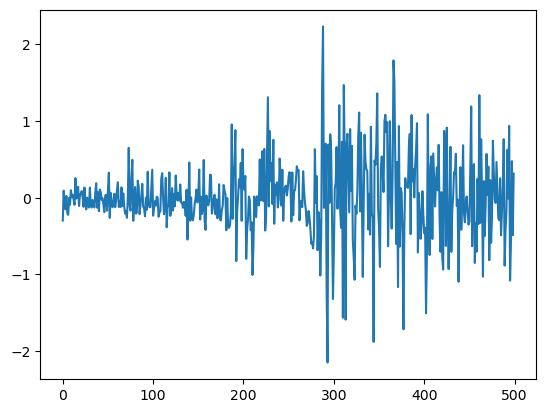

In [60]:
plt.plot(model_arima.resid)

In [38]:
# 残差
resid = model_arima.resid

# 平稳性检验
result = adfuller(resid)
print(result[1]) # 小于0.05，拒绝原假设，残差不存在单位根，即残差平稳

# 白噪声检验
LjungBox = stattools.q_stat(stattools.acf(resid**2)[1:12],len(resid)) #显示第1个到第11个白噪声检验的p值
LjungBox[1]  #所有p值小于0.05，因此拒绝原假设，残差平方不是白噪声，残差具有ARCH效应

4.891185153141113e-08


array([1.33867856e-07, 3.86683586e-08, 2.20551616e-09, 8.45364285e-13,
       5.72569054e-20, 1.29635887e-23, 4.12803194e-25, 3.94532127e-25,
       5.56189834e-26, 2.96997308e-27, 1.67267719e-30])

Optimization terminated successfully    (Exit mode 0)
            Current function value: 234.18386222908032
            Iterations: 16
            Function evaluations: 125
            Gradient evaluations: 15
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -234.184
Distribution:                  Normal   AIC:                           480.368
Method:            Maximum Likelihood   BIC:                           505.655
                                        No. Observations:                  500
Date:                Wed, Jun 07 2023   Df Residuals:                      499
Time:                        16:38:39   Df Model:                            1
                                  Mean Model                                 


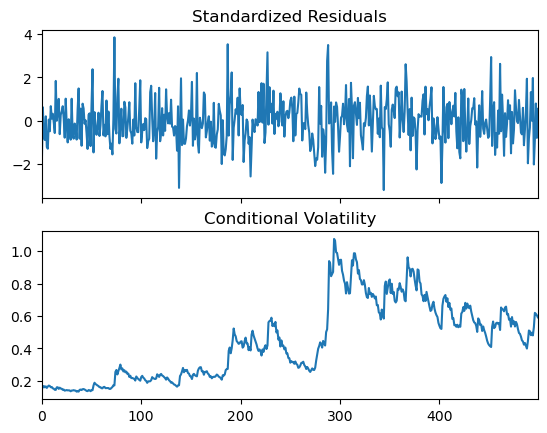

In [63]:
# 进行 GARCH 建模
from arch import arch_model

model_garch = arch_model(y=resid, p=2,q=2) #默认模型为GARCH（1，1）
model_garch = model_garch.fit(update_freq=0) #估计参数
print(model_garch.summary())
model_garch.plot();


In [67]:
model_garch.forecast(horizon=3, start=0).mean

,h.1,h.2,h.3
0,-0.010437,-0.010437,-0.010437
1,-0.010437,-0.010437,-0.010437
2,-0.010437,-0.010437,-0.010437
3,-0.010437,-0.010437,-0.010437
4,-0.010437,-0.010437,-0.010437
...,...,...,...
495,-0.010437,-0.010437,-0.010437
496,-0.010437,-0.010437,-0.010437
497,-0.010437,-0.010437,-0.010437
498,-0.010437,-0.010437,-0.010437


In [68]:
print(model_garch.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -234.184
Distribution:                  Normal   AIC:                           480.368
Method:            Maximum Likelihood   BIC:                           505.655
                                        No. Observations:                  500
Date:                Wed, Jun 07 2023   Df Residuals:                      499
Time:                        16:38:39   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu            -0.0104  1.354e-02     -0.771      0.441 

## Low-freq forecast

In [30]:
# data preparation helper
from hybrid_model import prepare_data_BPNN, prepare_data_LSTM_GRU, prepare_data_TCN
from hybrid_model import forecast_BPNN, forecast_LSTM, forecast_GRU, forecast_TCN

# visualization helper
def vis_model_performance(model, Dtr, scalar):
    real = []
    pred = []
    model.eval()
    with torch.no_grad():
        for seq, label in Dtr:
            y_pred = model(seq)
            real.extend(label.detach().numpy())
            pred.extend(y_pred.detach().numpy())
    pred = scalar.inverse_transform(np.array(pred).reshape(-1,1)).reshape(-1)
    real = scalar.inverse_transform(np.array(real).reshape(-1,1)).reshape(-1)
    rmse = np.sqrt(np.mean( np.square(np.array(real)-np.array(pred)) ))
    plt.figure()
    plt.title('RMSE = %f'%rmse)
    plt.plot(real, label='real')
    plt.plot(pred, label='pred')
    plt.legend()
    plt.show()
    return

### BPNN

In [13]:
lo_freq_pred, model_bpnn = forecast_BPNN(lo_freq)
lo_freq_pred

epoch 001 train_loss 0.00002533 val_loss 0.00000406
epoch 002 train_loss 0.00002391 val_loss 0.00000416
EarlyStopping counter: 1 out of 7
epoch 003 train_loss 0.00002085 val_loss 0.00000287
epoch 004 train_loss 0.00001954 val_loss 0.00000243
epoch 005 train_loss 0.00001867 val_loss 0.00000235
epoch 006 train_loss 0.00001791 val_loss 0.00000252
EarlyStopping counter: 1 out of 7
epoch 007 train_loss 0.00001735 val_loss 0.00000299
EarlyStopping counter: 2 out of 7
epoch 008 train_loss 0.00001697 val_loss 0.00000372
EarlyStopping counter: 3 out of 7
epoch 009 train_loss 0.00001676 val_loss 0.00000455
EarlyStopping counter: 4 out of 7
epoch 010 train_loss 0.00001668 val_loss 0.00000529
EarlyStopping counter: 5 out of 7
epoch 011 train_loss 0.00001666 val_loss 0.00000586
EarlyStopping counter: 6 out of 7
epoch 012 train_loss 0.00001667 val_loss 0.00000626
EarlyStopping counter: 7 out of 7
Early stopping


25.602404

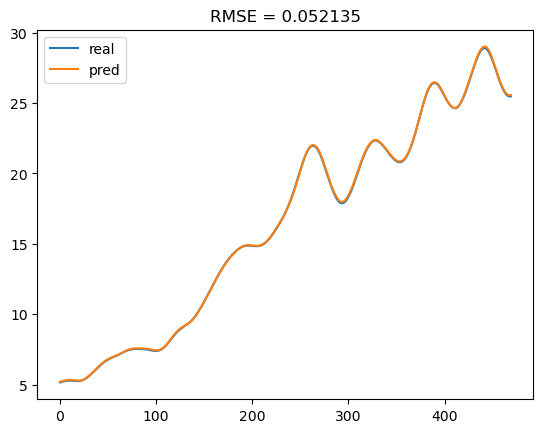

In [14]:
# visualize
Dtr, _, _, scalar = prepare_data_BPNN(lo_freq, seq_len=30, random=False)
vis_model_performance(model_bpnn, Dtr, scalar)

### LSTM

In [15]:
lo_freq_pred, model_lstm = forecast_LSTM(lo_freq)
lo_freq_pred

epoch 001 train_loss 0.00000184 val_loss 0.00000040
epoch 002 train_loss 0.00000184 val_loss 0.00000101
EarlyStopping counter: 1 out of 7
epoch 003 train_loss 0.00000150 val_loss 0.00000034
epoch 004 train_loss 0.00000113 val_loss 0.00000295
EarlyStopping counter: 1 out of 7
epoch 005 train_loss 0.00000126 val_loss 0.00000460
EarlyStopping counter: 2 out of 7
epoch 006 train_loss 0.00000131 val_loss 0.00000510
EarlyStopping counter: 3 out of 7
epoch 007 train_loss 0.00000136 val_loss 0.00000518
EarlyStopping counter: 4 out of 7
epoch 008 train_loss 0.00000138 val_loss 0.00000554
EarlyStopping counter: 5 out of 7
epoch 009 train_loss 0.00000137 val_loss 0.00000594
EarlyStopping counter: 6 out of 7
epoch 010 train_loss 0.00000137 val_loss 0.00000628
EarlyStopping counter: 7 out of 7
Early stopping


25.479486

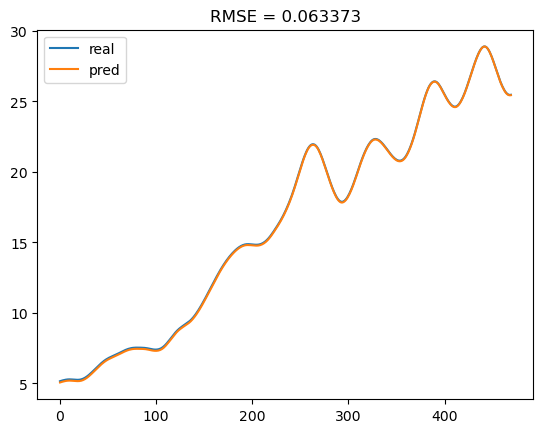

In [16]:
# visualize
Dtr, _, _, scalar = prepare_data_LSTM_GRU(lo_freq, seq_len=30, random=False)
vis_model_performance(model_lstm, Dtr, scalar)

### GRU

In [17]:
lo_freq_pred, model_gru = forecast_GRU(lo_freq)
lo_freq_pred

epoch 001 train_loss 0.00000080 val_loss 0.00000028
epoch 002 train_loss 0.00000086 val_loss 0.00000035
EarlyStopping counter: 1 out of 7
epoch 003 train_loss 0.00000096 val_loss 0.00000519
EarlyStopping counter: 2 out of 7
epoch 004 train_loss 0.00000108 val_loss 0.00001324
EarlyStopping counter: 3 out of 7
epoch 005 train_loss 0.00000124 val_loss 0.00000030
EarlyStopping counter: 4 out of 7
epoch 006 train_loss 0.00000064 val_loss 0.00001194
EarlyStopping counter: 5 out of 7
epoch 007 train_loss 0.00000109 val_loss 0.00000341
EarlyStopping counter: 6 out of 7
epoch 008 train_loss 0.00000085 val_loss 0.00001093
EarlyStopping counter: 7 out of 7
Early stopping


25.423796

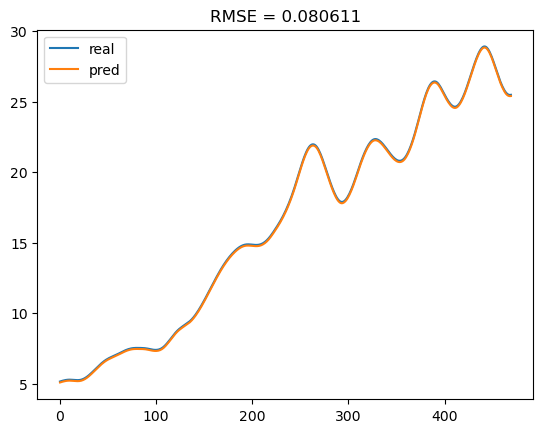

In [18]:
# visualize
Dtr, _, _, scalar = prepare_data_LSTM_GRU(lo_freq, seq_len=30, random=False)
vis_model_performance(model_gru, Dtr, scalar)

### TCN

In [49]:
lo_freq_pred, model_tcn = forecast_TCN(lo_freq)
lo_freq_pred

epoch 001 train_loss 0.00024240 val_loss 0.00021928
epoch 002 train_loss 0.00023524 val_loss 0.00021669
epoch 003 train_loss 0.00023298 val_loss 0.00021763
EarlyStopping counter: 1 out of 7
epoch 004 train_loss 0.00023162 val_loss 0.00022021
EarlyStopping counter: 2 out of 7
epoch 005 train_loss 0.00023115 val_loss 0.00022586
EarlyStopping counter: 3 out of 7
epoch 006 train_loss 0.00023235 val_loss 0.00022269
EarlyStopping counter: 4 out of 7
epoch 007 train_loss 0.00023042 val_loss 0.00022219
EarlyStopping counter: 5 out of 7
epoch 008 train_loss 0.00023148 val_loss 0.00022005
EarlyStopping counter: 6 out of 7
epoch 009 train_loss 0.00023043 val_loss 0.00022361
EarlyStopping counter: 7 out of 7
Early stopping


26.455309

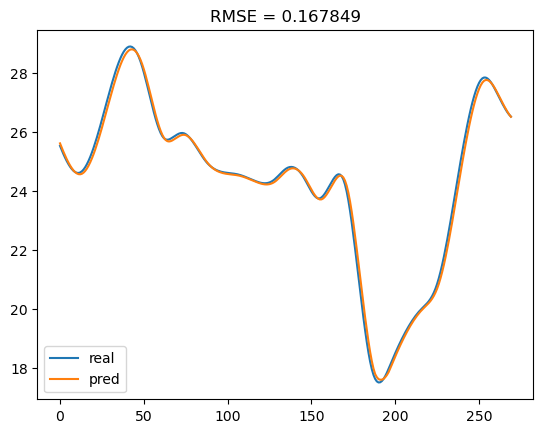

In [50]:
# visualize
Dtr, _, _, scalar = prepare_data_TCN(lo_freq, seq_len=30, random=False)
vis_model_performance(model_tcn, Dtr, scalar)

## Output

In [51]:
pred_out = hi_freq_pred + lo_freq_pred
print(pred_out)
print(win_y)

26.506347652039256
26.92


## Directly forecast without restructuring

In [49]:
direct_pred, model_direct_lstm = forecast_LSTM(win_x)
direct_pred

epoch 001 train_loss 0.00070492 val_loss 0.00062732
epoch 002 train_loss 0.00072099 val_loss 0.00063934
EarlyStopping counter: 1 out of 7
epoch 003 train_loss 0.00071584 val_loss 0.00064331
EarlyStopping counter: 2 out of 7
epoch 004 train_loss 0.00071702 val_loss 0.00064534
EarlyStopping counter: 3 out of 7
epoch 005 train_loss 0.00071261 val_loss 0.00064741
EarlyStopping counter: 4 out of 7
epoch 006 train_loss 0.00071004 val_loss 0.00064862
EarlyStopping counter: 5 out of 7
epoch 007 train_loss 0.00070765 val_loss 0.00064855
EarlyStopping counter: 6 out of 7
epoch 008 train_loss 0.00070539 val_loss 0.00064877
EarlyStopping counter: 7 out of 7
Early stopping


62.97192

#

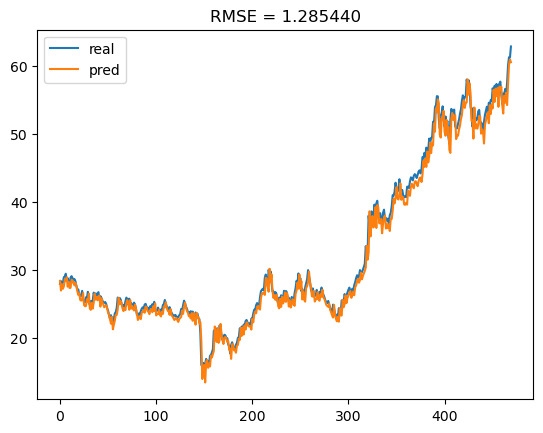

In [50]:
# visualize
Dtr, _, _, scalar = prepare_data_LSTM_GRU(win_x, seq_len=30, random=False)
vis_model_performance(model_direct_lstm, Dtr, scalar)

## Win-SSA

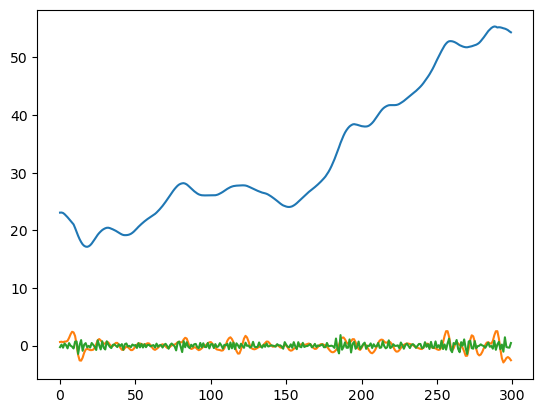

In [7]:
from series_restr import restr_ssa
reconstr = restr_ssa(win_x, n_decomp=10, n_integr=3)

plt.figure()
for i in range(len(reconstr)):
    plt.plot(reconstr[i])

In [8]:
from statsmodels.tsa import stattools
ssa_lo_freq = reconstr[0]
ssa_mi_freq = reconstr[1]
ssa_hi_freq = reconstr[2]
print(stattools.adfuller(ssa_lo_freq)[1])
print(stattools.adfuller(ssa_mi_freq)[1])
print(stattools.adfuller(ssa_hi_freq)[1])

0.9244824492630743
1.0240217673371821e-07
7.883692393873779e-20


-0.050184968732690544
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  300
Model:               SARIMAX(2, 0, 3)   Log Likelihood                 100.296
Date:                Fri, 09 Jun 2023   AIC                           -188.593
Time:                        22:35:10   BIC                           -166.370
Sample:                             0   HQIC                          -179.699
                                - 300                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4143      0.045      9.166      0.000       0.326       0.503
ar.L2         -0.6284      0.036    -17.294      0.000      -0.700      -0.557
ma.L1         -2.5490      0.3

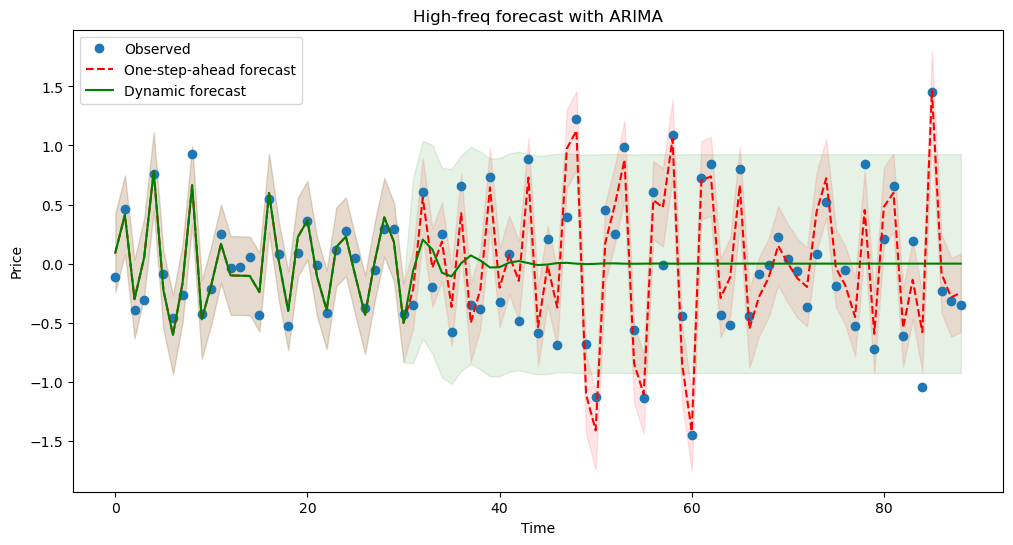

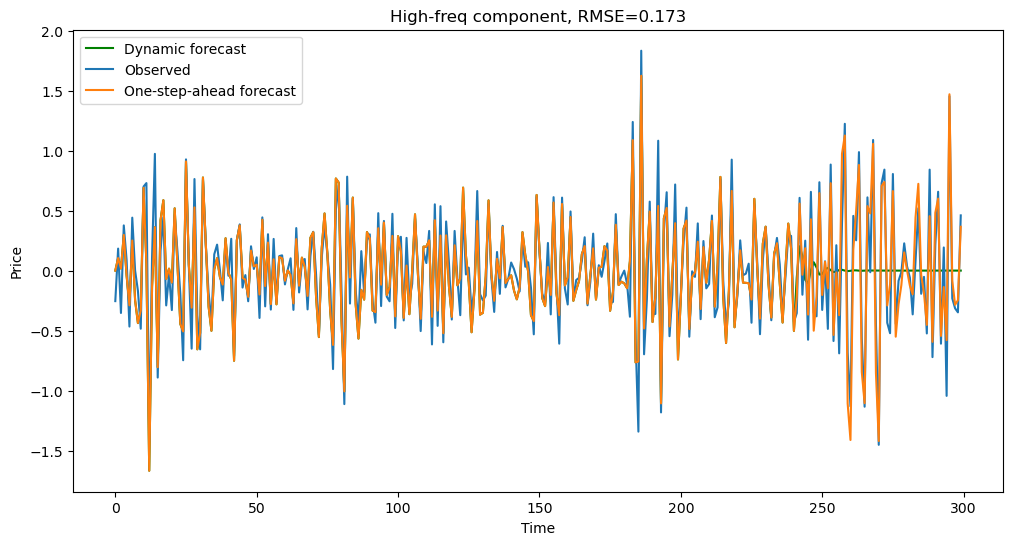

In [9]:
with HiddenPrints():
    ssa_hi_freq_pred, model_arima = forecast_arima(ssa_hi_freq)
print(ssa_hi_freq_pred)
plot_prediction(model_arima, ssa_hi_freq)

-2.3133650225909426
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  300
Model:               SARIMAX(4, 0, 4)   Log Likelihood                 152.879
Date:                Fri, 09 Jun 2023   AIC                           -287.758
Time:                        22:35:16   BIC                           -254.424
Sample:                             0   HQIC                          -274.418
                                - 300                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.6124      0.080     32.580      0.000       2.455       2.770
ar.L2         -2.9666      0.201    -14.748      0.000      -3.361      -2.572
ar.L3          1.8038      0.196

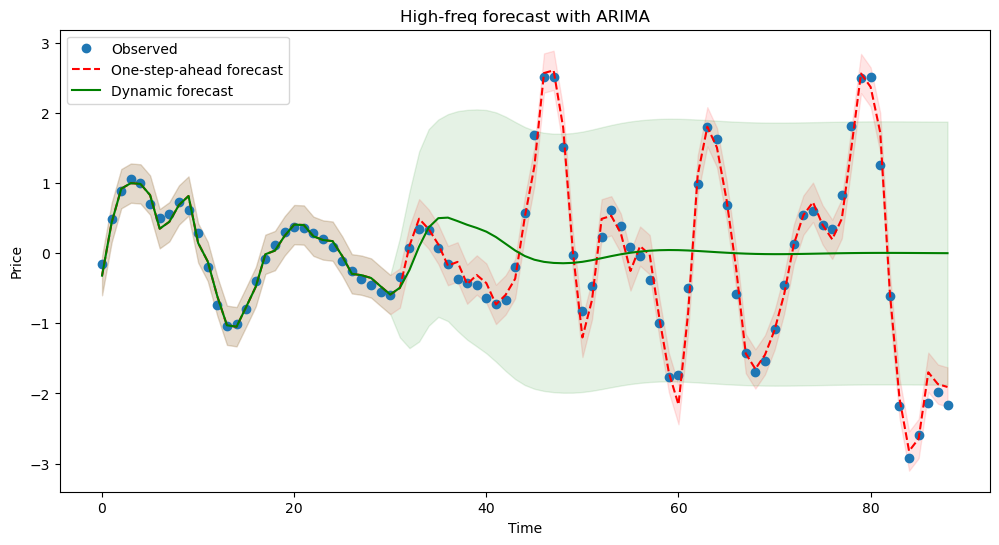

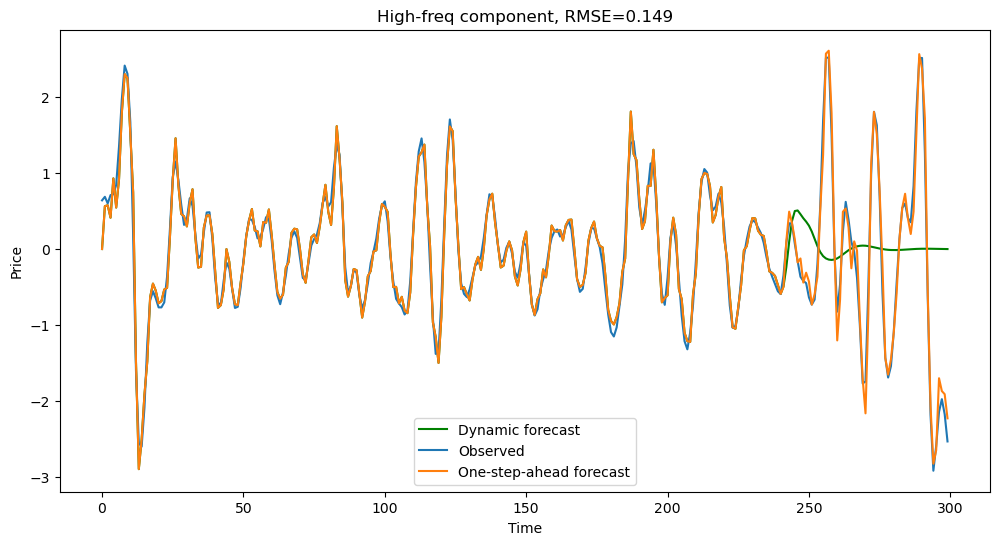

In [10]:
with HiddenPrints():
    ssa_hi_freq_pred, model_arima = forecast_arima(ssa_mi_freq)
print(ssa_hi_freq_pred)
plot_prediction(model_arima, ssa_mi_freq)

In [28]:
ssa_lo_freq_pred, model_tcn = forecast_TCN(ssa_lo_freq, 'ssa_tcn')
print(ssa_lo_freq_pred)


epoch 001 train_loss 0.04453675 val_loss 0.03519986
epoch 002 train_loss 0.02496326 val_loss 0.01179773
epoch 003 train_loss 0.01512724 val_loss 0.00481195
epoch 004 train_loss 0.01287799 val_loss 0.00279001
epoch 005 train_loss 0.00707601 val_loss 0.00442855
EarlyStopping counter: 1 out of 7
epoch 006 train_loss 0.00754679 val_loss 0.00290906
EarlyStopping counter: 2 out of 7
epoch 007 train_loss 0.00541509 val_loss 0.00212720
epoch 008 train_loss 0.00545814 val_loss 0.00190209
epoch 009 train_loss 0.00415101 val_loss 0.00132728
epoch 010 train_loss 0.00332452 val_loss 0.00128371
epoch 011 train_loss 0.00303870 val_loss 0.00128263
epoch 012 train_loss 0.00320303 val_loss 0.00115613
epoch 013 train_loss 0.00242471 val_loss 0.00128013
EarlyStopping counter: 1 out of 7
epoch 014 train_loss 0.00212922 val_loss 0.00125710
EarlyStopping counter: 2 out of 7
epoch 015 train_loss 0.00204941 val_loss 0.00101057
epoch 016 train_loss 0.00201044 val_loss 0.00118441
EarlyStopping counter: 1 out of 

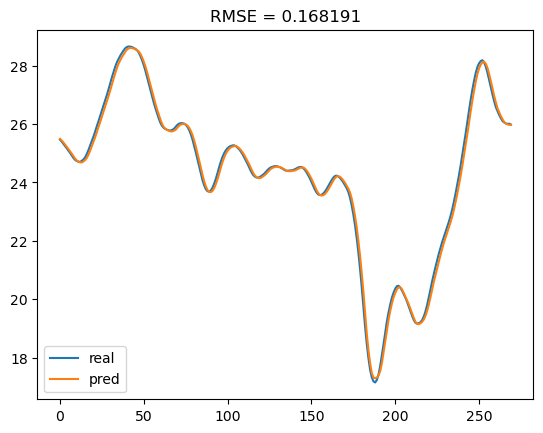

In [31]:
# visualize
Dtr, _, _, scalar = prepare_data_TCN(ssa_lo_freq, seq_len=30, random=False)
vis_model_performance(model_tcn, Dtr, scalar)

## SVR

In [ ]:
# from sklearn.model_selection import train_test_split 
from sklearn.svm import SVR
from sklearn.metrics import r2_score


# x = 

x = np.random.randn(80, 2)
y = x[:, 0] + 2*x[:, 1] + np.random.randn(80)

clf = SVR(kernel='linear', C=1.25)
x_tran,x_test,y_train,y_test = train_test_split(x, y, test_size=0.25)
clf.fit(x_tran, y_train)
y_hat = clf.predict(x_test)

print("得分:", r2_score(y_test, y_hat))

r = len(x_test) + 1
print(y_test)
plt.plot(np.arange(1,r), y_hat, 'go-', label="predict")
plt.plot(np.arange(1,r), y_test, 'co-', label="real")
plt.legend()
plt.show()